## 1. Libraries

In [ ]:
pip install folium --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [3]:
# Reading all the files
olist_customer = pd.read_csv(r"D:\NIT 10AM\project\personal\e-commerce-sentiment-analysis-eda-viz-nlp\datasets\data\olist_customers_dataset.csv")
olist_geolocation = pd.read_csv(r"D:\NIT 10AM\project\personal\e-commerce-sentiment-analysis-eda-viz-nlp\datasets\data\olist_geolocation_dataset.csv")
olist_orders = pd.read_csv(r"D:\NIT 10AM\project\personal\e-commerce-sentiment-analysis-eda-viz-nlp\datasets\data\olist_orders_dataset.csv")
olist_order_items = pd.read_csv(r"D:\NIT 10AM\project\personal\e-commerce-sentiment-analysis-eda-viz-nlp\datasets\data\olist_order_items_dataset.csv")
olist_order_payments = pd.read_csv(r"D:\NIT 10AM\project\personal\e-commerce-sentiment-analysis-eda-viz-nlp\datasets\data\olist_order_payments_dataset.csv")
olist_order_reviews = pd.read_csv(r"D:\NIT 10AM\project\personal\e-commerce-sentiment-analysis-eda-viz-nlp\datasets\data\olist_order_reviews_dataset.csv")
olist_products = pd.read_csv(r"D:\NIT 10AM\project\personal\e-commerce-sentiment-analysis-eda-viz-nlp\datasets\data\olist_products_dataset.csv")
olist_sellers = pd.read_csv(r"D:\NIT 10AM\project\personal\e-commerce-sentiment-analysis-eda-viz-nlp\datasets\data\olist_sellers_dataset.csv")

#  An Overview from the Data

In [4]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

In [5]:

# Create a list of dataset names and datasets
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
# Perform data overview
df_overview = pd.DataFrame({})
name_col = []

for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_stats = pd.DataFrame({
        'feature': df.columns,
        'qtd_null': df.isnull().sum(),
        'percent_null': df.isnull().mean() * 100,
        'dtype': df.dtypes,
        'qtd_cat': df.astype('category').nunique()
    })
    df_stats['dataset_name'] = name
    df_overview = pd.concat([df_overview, df_stats])

df_overview = df_overview[['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview.reset_index(drop=True, inplace=True)
df_overview


dataset_name                        feature  qtd_null  \
0         olist_customer                    customer_id         0   
1         olist_customer             customer_unique_id         0   
2         olist_customer       customer_zip_code_prefix         0   
3         olist_customer                  customer_city         0   
4         olist_customer                 customer_state         0   
5      olist_geolocation    geolocation_zip_code_prefix         0   
6      olist_geolocation                geolocation_lat         0   
7      olist_geolocation                geolocation_lng         0   
8      olist_geolocation               geolocation_city         0   
9      olist_geolocation              geolocation_state         0   
10          olist_orders                       order_id         0   
11          olist_orders                    customer_id         0   
12          olist_orders                   order_status         0   
13          olist_orders       order_purchase_timestamp         0   
14          olist_orders              order_approved_at       160   
15          olist_orders   order_delivered_carrier_date      1783   
16          olist_orders  order_delivered_customer_date      2965   
17          olist_orders  order_estimated_delivery_date         0   
18     olist_order_items                       order_id         0   
19     olist_order_items                  order_item_id         0   
20     olist_order_items                     product_id         0   
21     olist_order_items                      seller_id         0   
22     olist_order_items            shipping_limit_date         0   
23     olist_order_items                          price         0   
24     olist_order_items                  freight_value         0   
25  olist_order_payments                       order_id         0   
26  olist_order_payments             payment_sequential         0   
27  olist_order_payments                   payment_type         0   
28  olist_order_payments           payment_installments         0   
29  olist_order_payments                  payment_value         0   
30   olist_order_reviews                      review_id         0   
31   olist_order_reviews                       order_id         0   
32   olist_order_reviews                   review_score         0   
33   olist_order_reviews           review_comment_title     88285   
34   olist_order_reviews         review_comment_message     58247   
35   olist_order_reviews           review_creation_date         0   
36   olist_order_reviews        review_answer_timestamp         0   
37        olist_products                     product_id         0   
38        olist_products          product_category_name       610   
39        olist_products            product_name_lenght       610   
40        olist_products     product_description_lenght       610   
41        olist_products             product_photos_qty       610   
42        olist_products               product_weight_g         2   
43        olist_products              product_length_cm         2   
44        olist_products              product_height_cm         2   
45        olist_products               product_width_cm         2   
46         olist_sellers                      seller_id         0   
47         olist_sellers         seller_zip_code_prefix         0   
48         olist_sellers                    seller_city         0   
49         olist_sellers                   seller_state         0   

    percent_null    dtype  qtd_cat  
0       0.000000   object    99441  
1       0.000000   object    96096  
2       0.000000    int64    14994  
3       0.000000   object     4119  
4       0.000000   object       27  
5       0.000000    int64    19015  
6       0.000000  float64   717360  
7       0.000000  float64   717613  
8       0.000000   object     8011  
9       0.000000   object       27  
10      0.000000   object    99441  
11      0.000000   object    99441  
12      0.0

Well, we can now use the DataFrame above wherever we want to do dome data transformation or data analysis. It contains basically the main information about each column for each one of the datasets available. This is very useful!

# Exploratory Data Analysis (EDA)

##So now we will go trough an exploratory data analysis to get insights from E-Commerce in Brazil. The aim here is to divide this session into topics so we can explore graphics for each subject (orders, customers, products, items, and others).

## Total Orders on E-Commerce

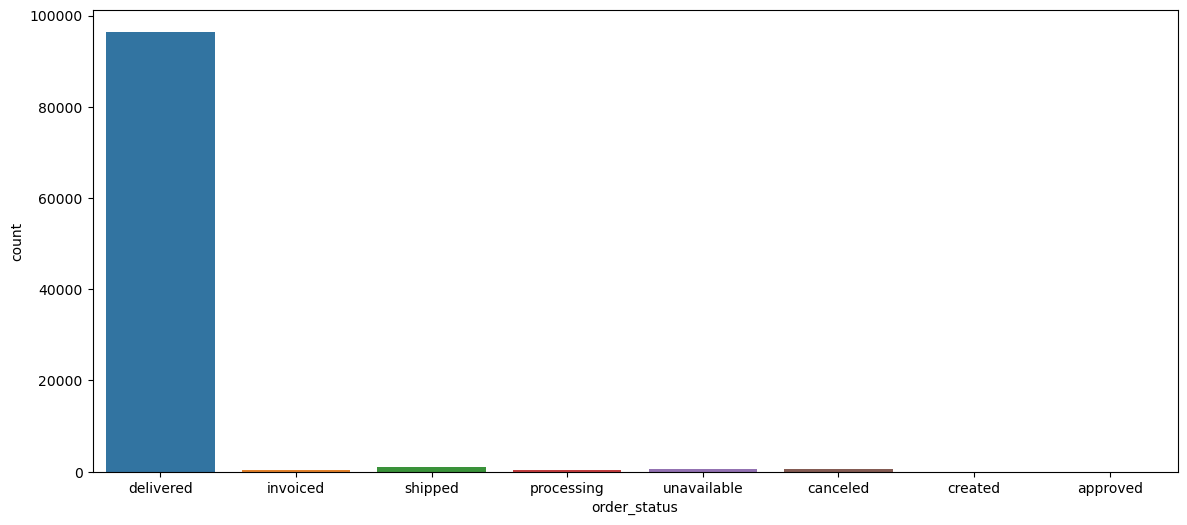

In [6]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(data=df_orders, x='order_status', ax=ax)
plt.show()


In [7]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  
0                   10                 Morning  
1                   20                   Night  
2                    8                 Morning  
3                   19                   Night  
4                   21                   Night

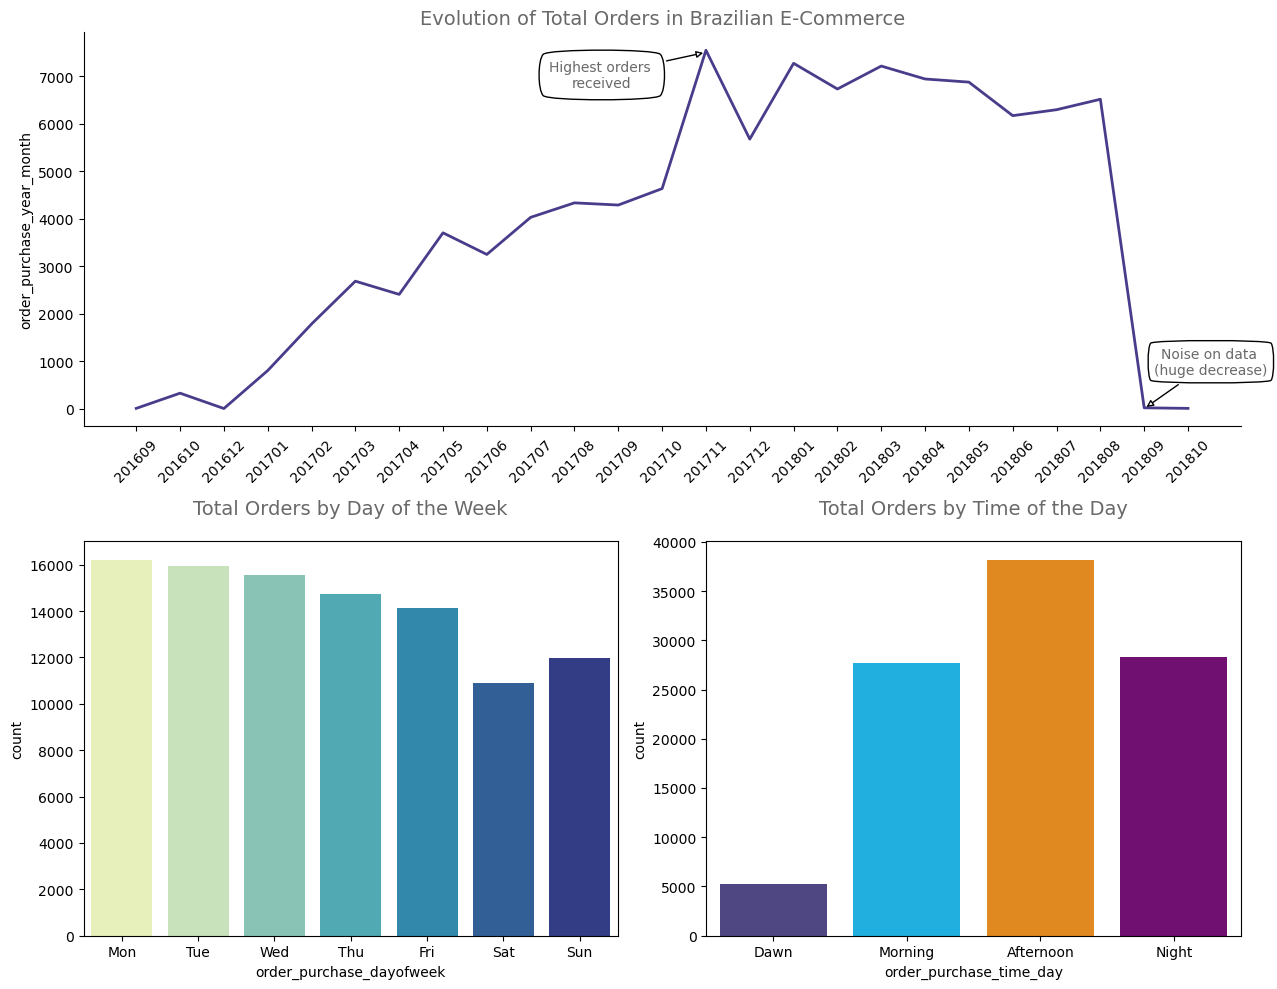

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1,
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25),
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25),
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of the week
sns.countplot(data=df_orders, x='order_purchase_dayofweek', ax=ax2, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of the Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
sns.countplot(data=df_orders, x='order_purchase_time_day', ax=ax3, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()


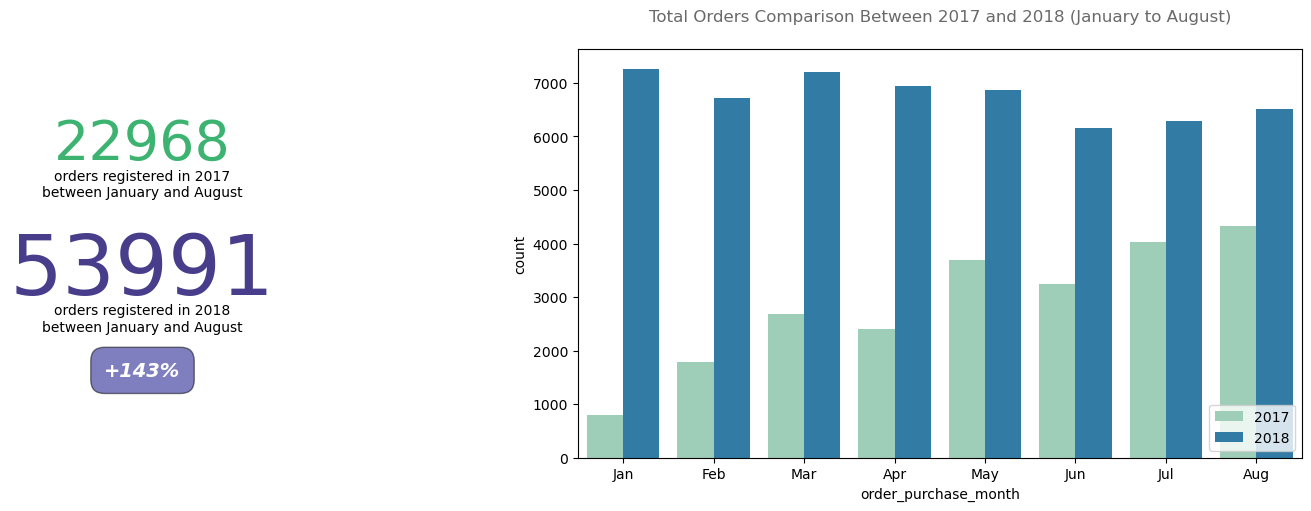

In [9]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
sns.countplot(data=df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2,
              palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
ax2.legend(loc='lower right')
plt.show()


## E-Commerce Around Brazil

In [10]:
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


In [11]:
import requests

# Merging orders and order_items
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Using the API to bring the region to the data
try:
    r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes', verify=False)
    content = [c['UF'] for c in json.loads(r.text)]
    br_info = pd.DataFrame(content)
    br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
    br_info.drop('regiao', axis=1, inplace=True)
    br_info.drop_duplicates(inplace=True)
except requests.exceptions.SSLError as e:
    print("SSL certificate verification failed. Error:", e)

# Rest of the code for data preprocessing and merging
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
geo_prep = geo_prep[geo_prep.geolocation_lng <= -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  order_item_id  \
0                   10                 Morning            1.0   
1                   20                   Night            1.0   
2                    8                 Morning            1.0   
3                   19                   Night            1.0   
4                   21                   Night            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b

## An overview of customer's order by region, state and city

In [12]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

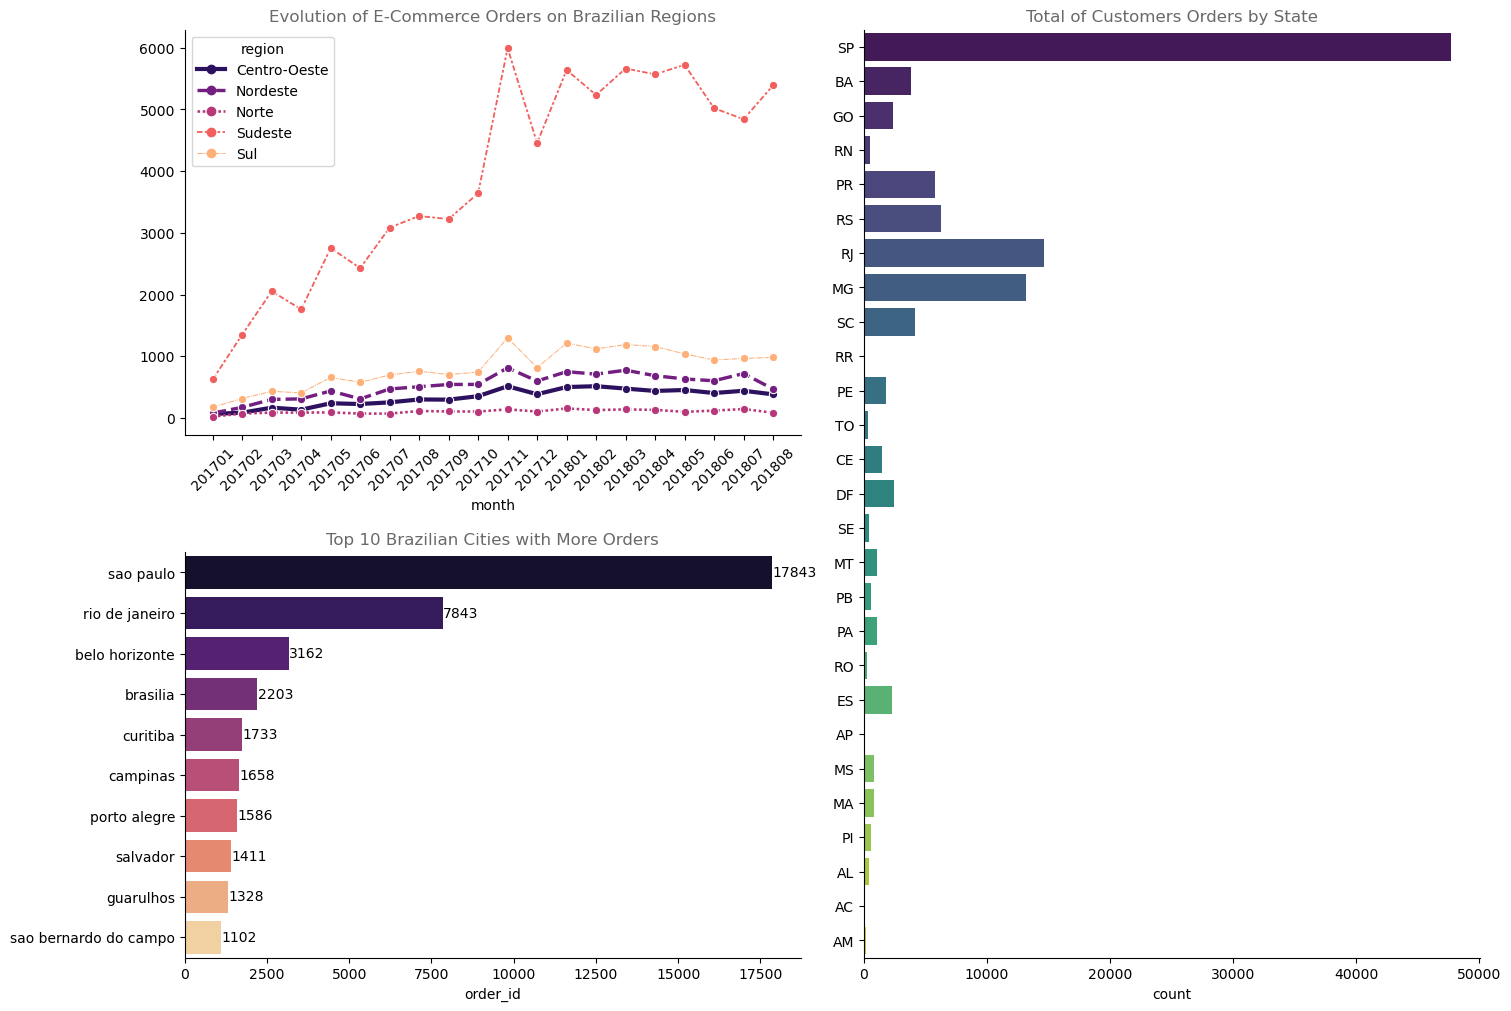

In [13]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='magma', markers=['o'] * 5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')
for i, v in enumerate(df_cities_group['order_id']):
    ax2.text(v + 10, i, str(v), color='black', fontsize=10, va='center')
    
# Total orders by state
sns.countplot(y='customer_state', data=df_orders_filt, ax=ax3, palette='viridis')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Total of Customers Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')

plt.show()


In [14]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

HeatMaps: a good view to see where are the core of brazilian e-commerce customers

By the map we showed above, we have already the insight that the southeast of Brazil has the highest number of orders given through e-commerce. So, let's see it in a HeatMap!

In [15]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(map1)

map1

Nice! Another good view is to use the folium plugin HeatMapWithTime to see the evolution of e-commerce orders among time.

For limitations purpose (i.e. jupyter and Chrome limitations for total number of points shown at HeatMapWithTime, we will show the evolution of orders from January 2018 to July 2018)

Also, it's possible that the plugin HeatMapWithTime doesn't work properly from a issue fixed on version 0.11 (it's seems that the version of the kernel is 0.10). It it is the case for you, just updating the version of folium library would fix it.

In [16]:
epoch_list = []
heatmap_evl_data = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201801)]
heatmap_evl_data = heatmap_evl_data[(heatmap_evl_data['order_purchase_year_month'].astype(int) <= 201807)]
time_index = heatmap_evl_data['order_purchase_year_month'].sort_values().unique()
for epoch in time_index:
    data_temp = heatmap_evl_data.query('order_purchase_year_month == @epoch')
    data_temp = data_temp.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count()
    data_temp = data_temp.sort_values(by='order_id', ascending=False).iloc[:, :3]
    epoch_list.append(data_temp.values.tolist())
    
# Creating a mapa using folium
map2 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMapWithTime
HeatMapWithTime(
    name='Evolution of Orders in a Geolocation Perspective',
    data=epoch_list,
    radius=10,
    index=list(time_index)
).add_to(map2)

map2

 E-Commerce Impact on Economy

In [17]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

order_purchase_year order_purchase_year_month  order_id      price  \
0                 2017                    201701       966  120312.87   
1                 2017                    201702      1998  247303.02   
2                 2017                    201703      3041  374344.30   
3                 2017                    201704      2697  359927.23   
4                 2017                    201705      4176  506071.14   

   freight_value  price_per_order  freight_per_order  
0       16875.62       124.547484          17.469586  
1       38977.60       123.775285          19.508308  
2       57704.29       123.099079          18.975432  
3       52495.01       133.454664          19.464223  
4       80119.81       121.185618          19.185778

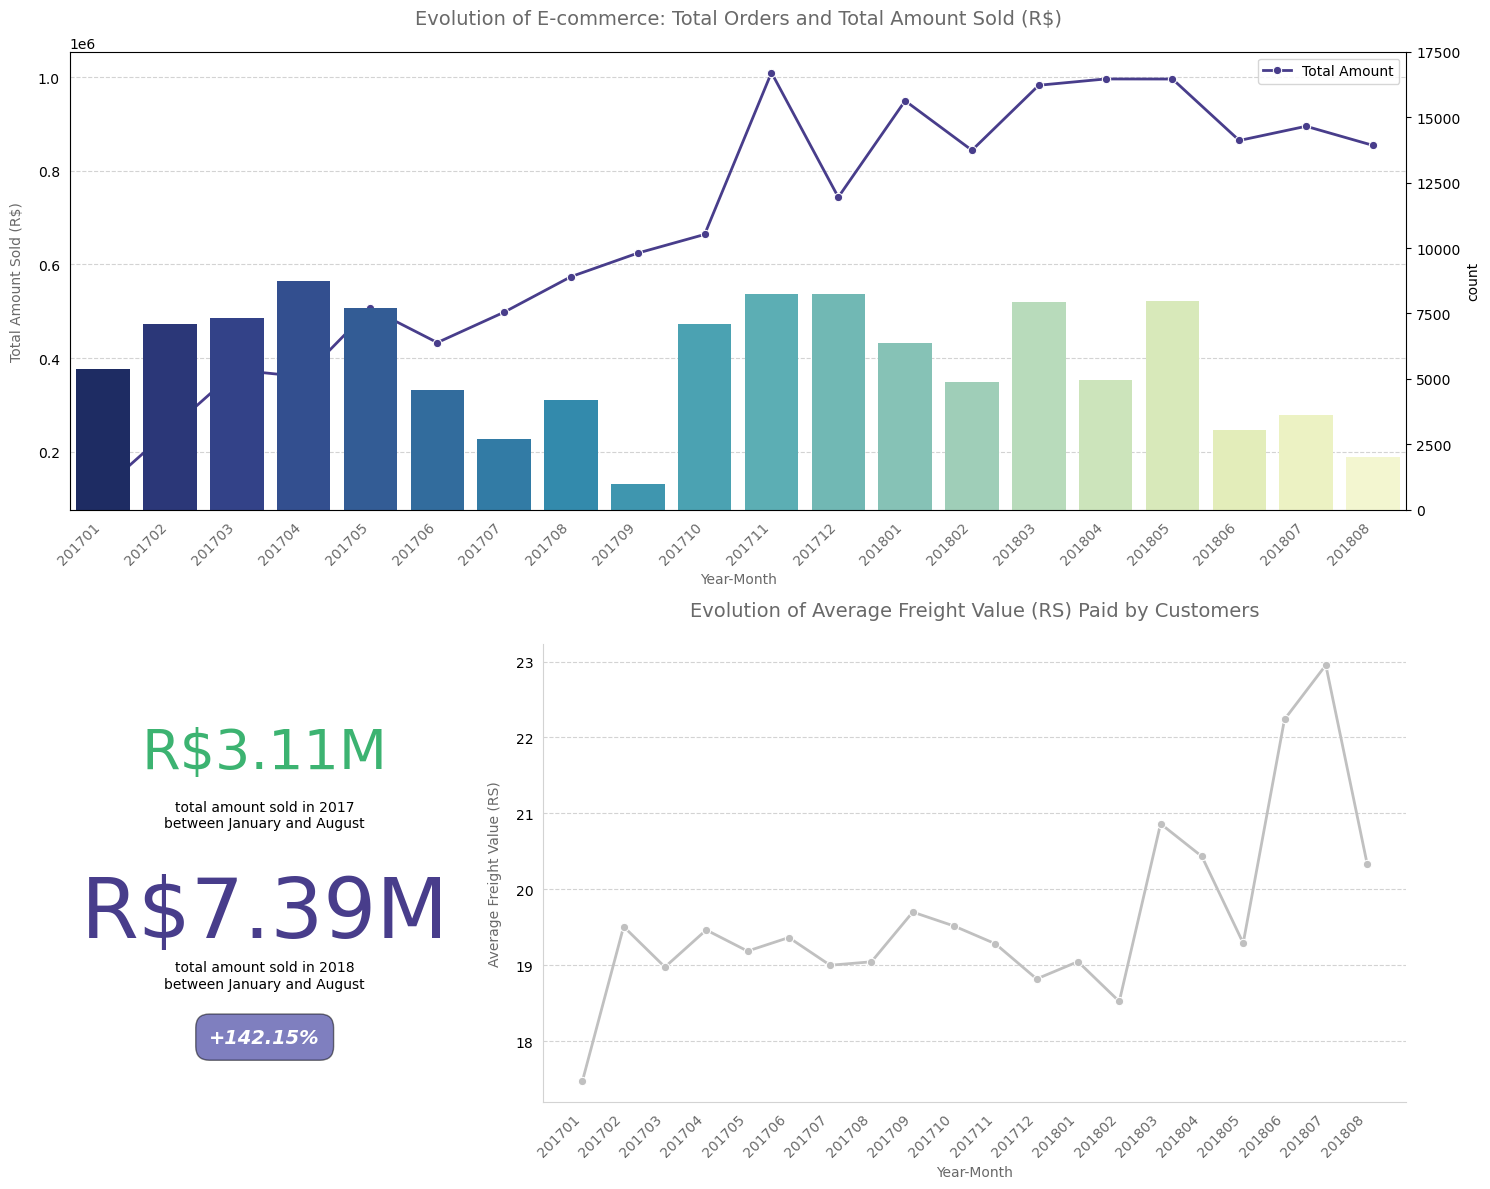

In [18]:
# Creating figure
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np

fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
sns.countplot(x='order_purchase_year_month', data=df_orders_filt, ax=ax1_twx, palette='YlGnBu_r')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_color('lightgray')
ax1.spines['left'].set_color('lightgray')

ax1.tick_params(bottom=False, left=False)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgray', linestyle='--')

ax1.set_xlabel('Year-Month', color='dimgrey')
ax1.set_ylabel('Total Amount Sold (R$)', color='dimgrey')
ax1.yaxis.labelpad = 10

ax1.set_xticks(df_month_aggreg.index)
ax1.set_xticklabels(df_month_aggreg['order_purchase_year_month'], rotation=45, ha='right', color='dimgrey')

ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_color('lightgray')
ax3.spines['left'].set_color('lightgray')

ax3.tick_params(bottom=False, left=False)
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='lightgray', linestyle='--')

ax3.set_xlabel('Year-Month', color='dimgrey')
ax3.set_ylabel('Average Freight Value (RS)', color='dimgrey')
ax3.yaxis.labelpad = 10

ax3.set_xticks(df_month_aggreg.index)
ax3.set_xticklabels(df_month_aggreg['order_purchase_year_month'], rotation=45, ha='right', color='dimgrey')

ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()


## Total Sales

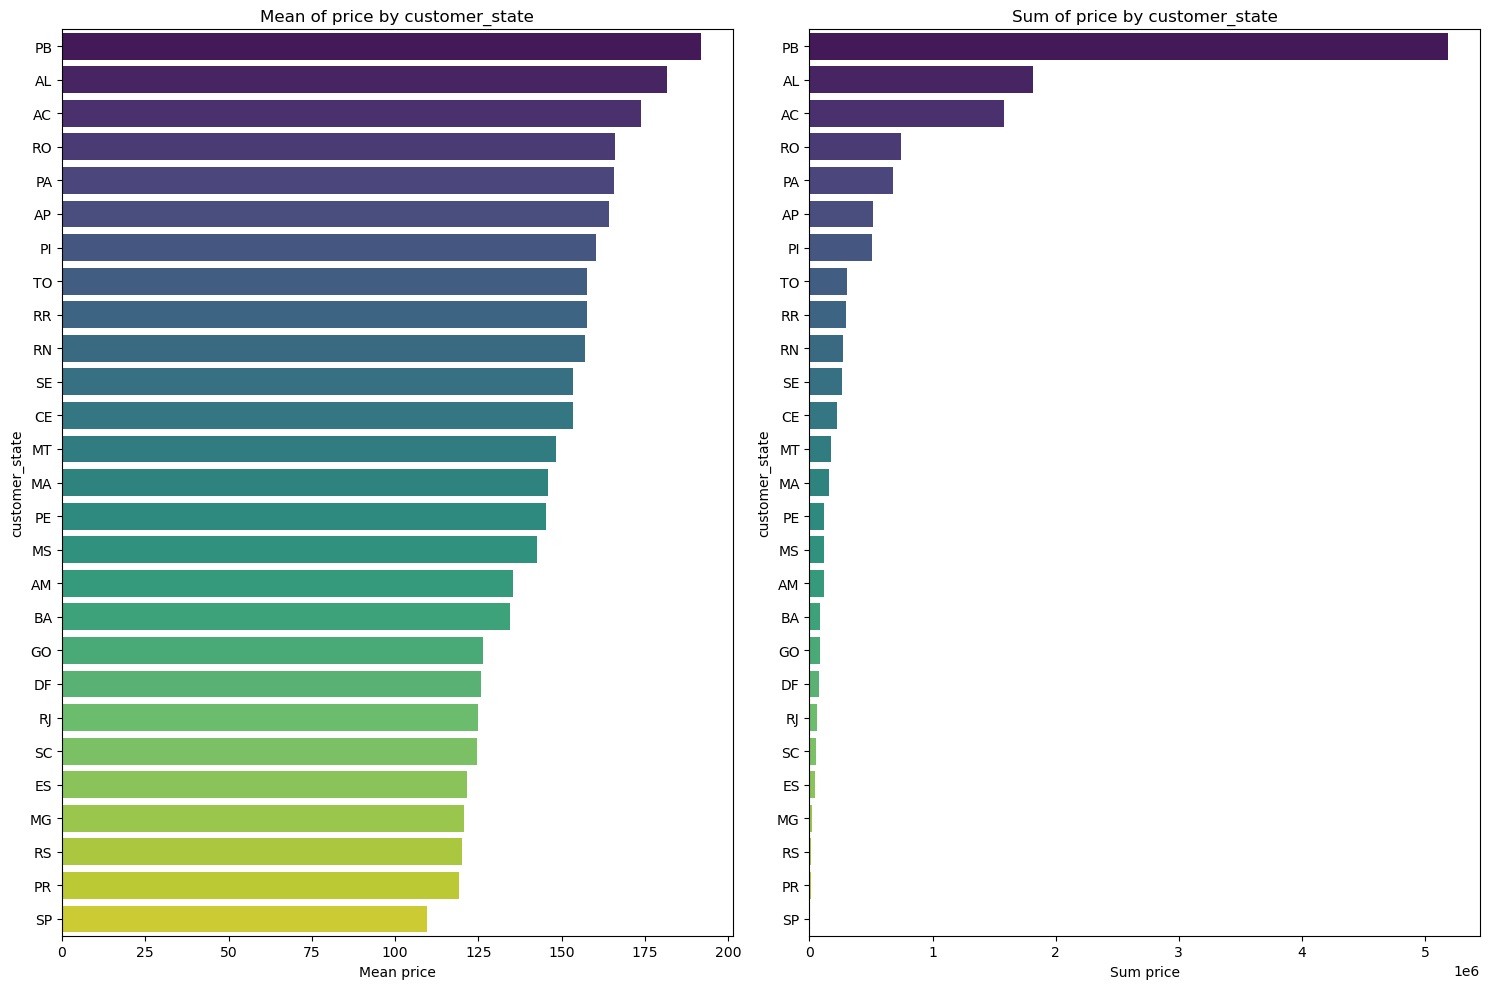

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def mean_sum_analysis(data, category_col, value_col, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    categories = data.groupby(category_col)[value_col].mean().sort_values(ascending=False).index
    mean_values = data.groupby(category_col)[value_col].mean().sort_values(ascending=False)
    sum_values = data.groupby(category_col)[value_col].sum().sort_values(ascending=False)
    bar_width = 0.35
    bar_height = 0.7
    index = np.arange(len(categories))

    # Plot the mean and sum values
    plt.subplot(1, 2, 1)
    sns.barplot(x=mean_values, y=categories, palette='viridis')
    plt.xlabel('Mean {}'.format(value_col))
    plt.ylabel(category_col)
    plt.title('Mean of {} by {}'.format(value_col, category_col))

    plt.subplot(1, 2, 2)
    sns.barplot(x=sum_values, y=categories, palette='viridis')
    plt.xlabel('Sum {}'.format(value_col))
    plt.ylabel(category_col)
    plt.title('Sum of {} by {}'.format(value_col, category_col))

    plt.tight_layout()
    plt.show()

mean_sum_analysis(df_orders_filt, 'customer_state', 'price', figsize=(15, 10))


## Freight

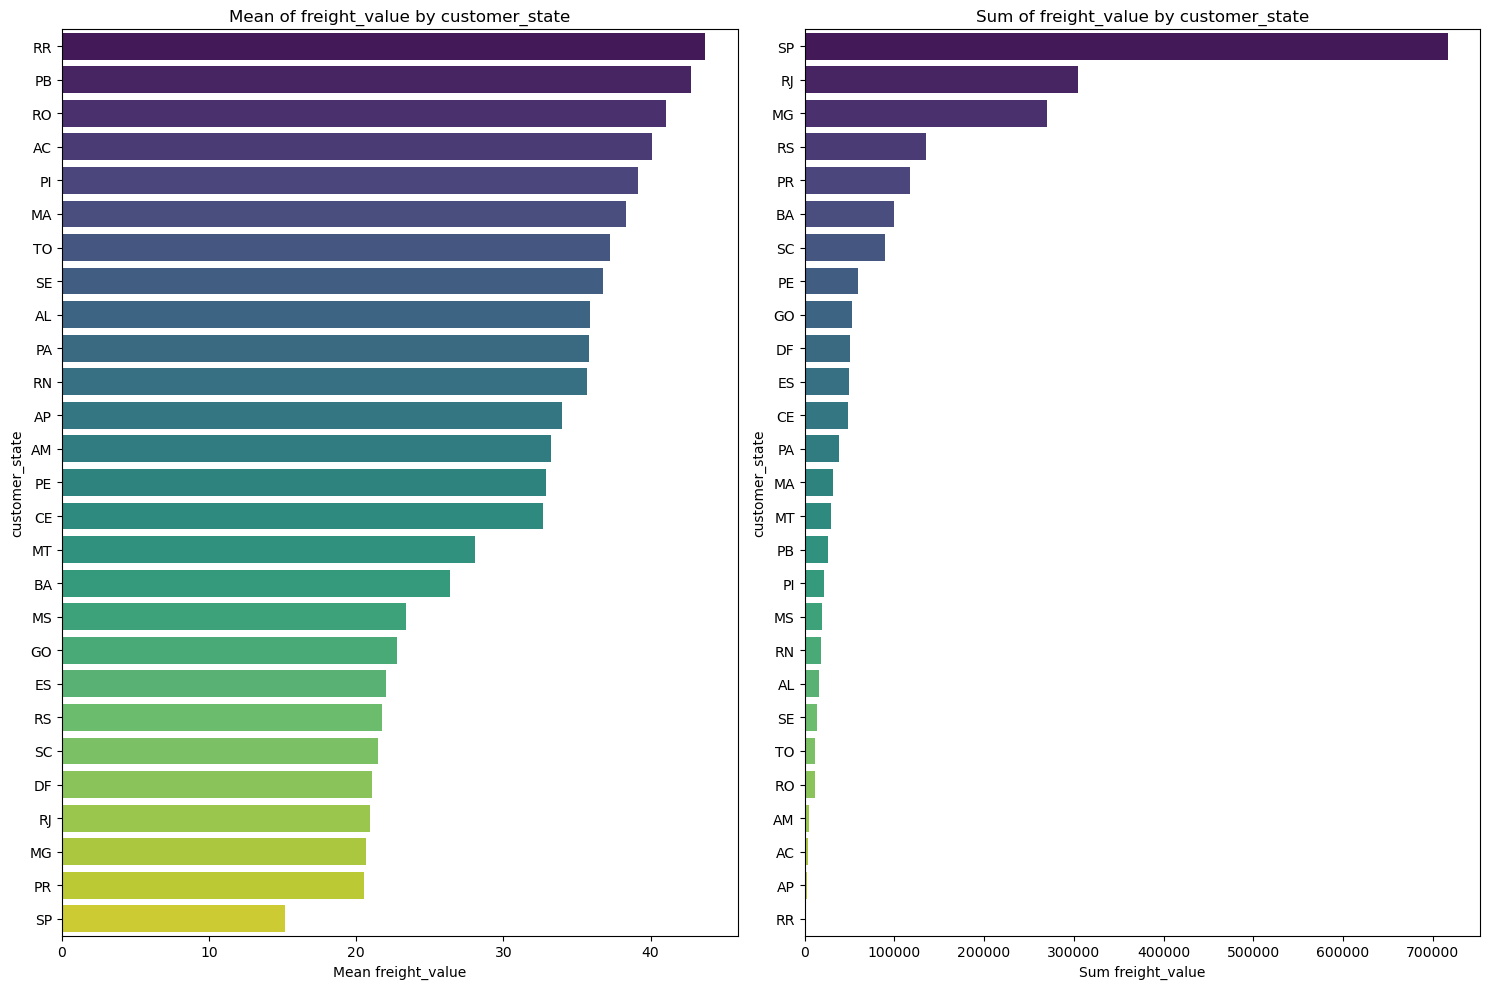

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def mean_sum_analysis(data, category_col, value_col, palette='viridis', figsize=(15, 10)):
    plt.figure(figsize=figsize)
    categories = data[category_col].unique()
    mean_values = data.groupby(category_col)[value_col].mean().sort_values(ascending=False)
    sum_values = data.groupby(category_col)[value_col].sum().sort_values(ascending=False)
    bar_height = 0.35
    bar_width = 0.7
    index = np.arange(len(categories))

    # Plot the mean values
    plt.subplot(1, 2, 1)
    sns.barplot(y=mean_values.index, x=mean_values.values, palette=palette)
    plt.xlabel('Mean {}'.format(value_col))
    plt.ylabel(category_col)
    plt.title('Mean of {} by {}'.format(value_col, category_col))

    # Plot the sum values
    plt.subplot(1, 2, 2)
    sns.barplot(y=sum_values.index, x=sum_values.values, palette=palette)
    plt.xlabel('Sum {}'.format(value_col))
    plt.ylabel(category_col)
    plt.title('Sum of {} by {}'.format(value_col, category_col))

    plt.tight_layout()
    plt.show()

mean_sum_analysis(df_orders_filt, 'customer_state', 'freight_value', palette='viridis', figsize=(15, 10))


## states to buy in Brazil? An analysis on sales, freight and delivery time

In [21]:
df_orders_filt['order_delivered_customer_date'] = pd.to_datetime(df_orders_filt['order_delivered_customer_date'])
df_orders_filt['order_purchase_timestamp'] = pd.to_datetime(df_orders_filt['order_purchase_timestamp'])

# Calculating working days between purchasing, delivering, and estimated delivery
df_orders_filt['time_to_delivery'] = (df_orders_filt['order_delivered_customer_date'] - df_orders_filt['order_purchase_timestamp']).dt.days
df_orders_filt['diff_estimated_delivery'] = (df_orders_filt['order_delivered_customer_date'] - df_orders_filt['order_estimated_delivery_date']).dt.days

# Grouping data by state
states_avg_grouped = df_orders_filt.groupby(by='customer_state', as_index=False).mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]

# Sorting data
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery', ascending=False)
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery')


In [22]:
from datetime import datetime, timedelta

def calc_working_days(start_date, end_date, convert=False):
    if convert:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
    
    working_days = 0
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday to Friday
            working_days += 1
        current_date += timedelta(days=1)
    
    return working_days


## Payment Type Analysis

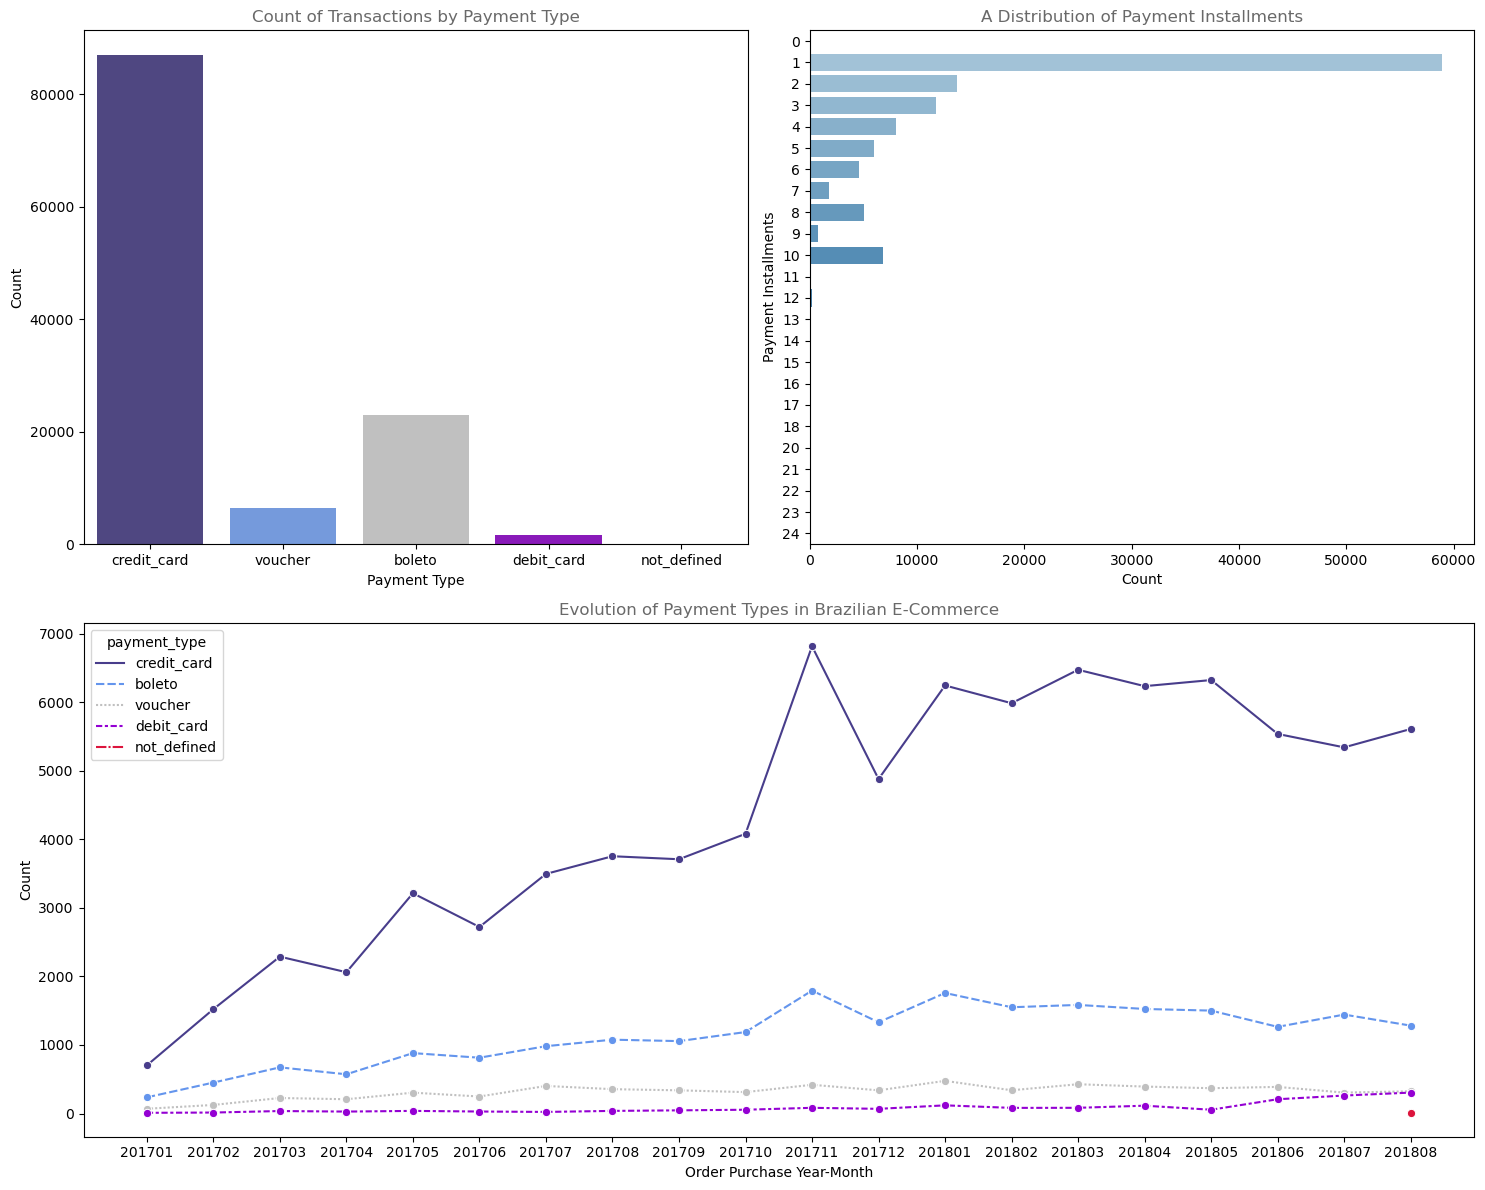

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping data
df_orders_pay = df_orders_filt.merge(olist_order_payments, how='left', on='order_id')

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Plot 1 - Payment types in a bar chart
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
sns.countplot(x='payment_type', data=df_orders_pay, ax=ax1, palette=colors)
ax1.set_title('Count of Transactions by Payment Type', size=12, color='dimgrey')
ax1.set_xlabel('Payment Type')
ax1.set_ylabel('Count')

# Plot 2 - Payment installments
sns.countplot(y='payment_installments', data=df_orders_pay, ax=ax2, palette='Blues_d')
ax2.set_title('A Distribution of Payment Installments', color='dimgrey', size=12)
ax2.set_xlabel('Count')
ax2.set_ylabel('Payment Installments')

# Plot 3 - Evolution of payment types
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', palette=colors, marker='o')
ax3.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=12, color='dimgrey')
ax3.set_xlabel('Order Purchase Year-Month')
ax3.set_ylabel('Count')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


# Natural Language Processing (NLP)

## Data Understanding

In [24]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (41753, 2)


score                                            comment
0      5              Recebi bem antes do prazo estipulado.
1      5  Parabéns lojas lannister adorei comprar pela I...
2      4  aparelho eficiente. no site a marca do aparelh...
3      4    Mas um pouco ,travando...pelo valor ta Boa.\r\n
4      5  Vendedor confiável, produto ok e entrega antes...

So, we have in hands approximately 41k comments that could be used for training a sentimental analysis model. But, for this to becoming true, we have to go trough a long way of text preparation to transform the comment input into a vector that can be interpreted for a Machine Learning model.

## Regular Expressions

As long as we consider the global internet as the source of our comments, probably we have to deal with some HTML tags, break lines, special characteres and other content that could be part of the dataset. Let's dig a little bit more on Regular Expressions to search for those patterns.

First of all, let's define a function that will be used for analysing the results of an applied regular expression. With whis we can validate our text pre processing in an easier way.

In [25]:
def find_patterns(re_pattern, text_list):
    """
    Args:
    ---------
    re_pattern: regular expression pattern to be used on search [type: string]
    text_list: list with text strings [type: list]
    
    Returns:
    positions_dict: python dictionary with key-value pars as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ... (start_n, end_n)]
    """
    
    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1
        
    """p = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    pattern_dict = find_patterns(p, reviews_breakline)
    print(len(pattern_dict))
    pattern_dict
    for idx in [int(c.split(' ')[-1]) for c in list(pattern_dict.keys())]:
        print(f'{reviews_breakline[idx]}\n')"""

    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list):
    """
    Args:
    ----------
    text_list_before: list object with text content before transformation [type: list]
    text_list_after: list object with text content after transformation [type: list]
    idx_list: list object with indexes to be printed [type: list]
    """
    
    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

Breakline and Carriage Return

In [26]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [27]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, idx_list=[48])

--- Text 1 ---

Before: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!
Tudo certo!

Att 

Elenice.

After: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!  Tudo certo!    Att     Elenice.



## Sites and Hiperlinks

In [28]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [29]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10796, 12782])

--- Text 1 ---

Before: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto http://prntscr.com/jkx7hr quando o produto chegou aqui veio todos com a mesma cor, tabaco http://prntscr.com/

After: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto  link  quando o produto chegou aqui veio todos com a mesma cor, tabaco  link 

--- Text 2 ---

Before: 
Pedi esse: https://www.lannister.com.br/produto/22880118/botox-capilar-selafix-argan-premium-doux-clair-2x1-litro?pfm_carac=doux%20clair&pfm_index=3&pfm_page=search&pfm_pos=grid&pfm_type=search_page%

After: 
Pedi esse:  link 



## Dates

Well, as long as we are dealing with customers reviews on items bought online, probably date mentions are very common. Let's see some examples and apply a RegEx to change this to data (means date in english).

In [30]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [31]:
# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26665, 41497, 41674])

--- Text 1 ---

Before: 
(tenso) tinhas mais de 10 lojas pra min escolher qual comprar, o pitei pela lannister por ser uma loja conhecida a entrega estava para dia 22/01/2018 . hoje já é 24/01/2018 pois comprei dia 06/01/18

After: 
(tenso) tinhas mais de 10 lojas pra min escolher qual comprar, o pitei pela lannister por ser uma loja conhecida a entrega estava para dia  data  . hoje já é  data  pois comprei dia  data 

--- Text 2 ---

Before: 
COMPREI EM 21/03/2018, PG VIA CARTÃO EM 21/03/2018, NF FOI EMITIDA DIA 27/03/2018, PREVISÃO ENTREGA EM 12/04/2018, HOJE É 14/04/2018, NÃO RECEBI, NÃO ESTÁ EM TRANSPORTE, ESTOU MUITO PREOCUPADO

After: 
COMPREI EM  data , PG VIA CARTÃO EM  data , NF FOI EMITIDA DIA  data , PREVISÃO ENTREGA EM  data , HOJE É  data , NÃO RECEBI, NÃO ESTÁ EM TRANSPORTE, ESTOU MUITO PREOCUPADO

--- Text 3 ---

Before: 
Já comprei várias vezes no site "lannister";mas  desta última vez,fiz uma compra de um TONER no  04.10.16 e só prometeram p/ 25.11.16 e ainda não  rece

##  Money

Another pattern that probably is very common on this kind of source is representations of money (R$ _,_). To improve our model, maybe it's a good idea to transform this pattern into a key word like valor (means money or amount in english).

In [32]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [33]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[26020, 33297, 32998])

--- Text 1 ---

Before: 
Recebi o produto correto, porém o valor do produto na NF ficou a menor, R$ 172,00 sendo que comprei a 219,90.  O valor do frete calculado foi R$ 18,90 e veio R$ 93,00.  Gostaria que viesse com correto

After: 
Recebi o produto correto, porém o valor do produto na NF ficou a menor,  dinheiro  sendo que comprei a 219,90.  O valor do frete calculado foi  dinheiro  e veio  dinheiro .  Gostaria que viesse com correto

--- Text 2 ---

Before: 
Infelizmente, para uma entrega em GRU (Região Metropolitana da Grande SP) achei bem "salgado" o valor do frete cobrado sobre o preço do produto! Afinal, a mercadoria custou R$26,70 + R$15,11 de frete!

After: 
Infelizmente, para uma entrega em GRU (Região Metropolitana da Grande SP) achei bem "salgado" o valor do frete cobrado sobre o preço do produto! Afinal, a mercadoria custou  dinheiro  +  dinheiro  de frete!

--- Text 3 ---

Before: 
Paguei $48,00 reais de frete e acabei tendo que buscar o pedido no Centro de Distribuição 

## Numbers

Here we will try to find numbers on reviews and replace them with another string numero (that means number, in english). We could just replace the numbers with whitespace but maybe this would generated some information loss. Let's see what we've got:

In [34]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [35]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.

After: 
Comprei o produto dia  numero  de fevereiro e hoje dia  numero  de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.



## Negation

This session was thought and discussed in a special way. The problem statement is that when we remove the stopwords, probabily we would loose the meaning of some phrases about removing the negation words like não (not), for example. So, because of this, maybe is a good idea to replace some negation words with some common words indicating a negation meaning.

In [36]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [37]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[4783, 4627, 4856, 4904])

--- Text 1 ---

Before: 
O material é bom, o problema é que a bolsa não fecha, não possui zíper, é como uma sacola. Isso me deixou insatisfeita, pois na foto não dá pra perceber e não há informação ou foto interna sobre isso.

After: 
O material é bom, o problema é que a bolsa  negação  fecha,  negação  possui zíper, é como uma sacola. Isso me deixou insatisfeita, pois na foto  negação  dá pra perceber e  negação  há informação ou foto interna sobre isso.

--- Text 2 ---

Before: 
Meu pedido era para ser entregue até dia  data , até a presente data ( numero / numero ) a nota fiscal não foi emitida, solicitei várias vezes não obtive retorno, não recomendo esta Loja, nem a lannister!!!!!!

After: 
Meu pedido era para ser entregue até dia  data , até a presente data ( numero / numero ) a nota fiscal  negação  foi emitida, solicitei várias vezes  negação  obtive retorno,  negação  recomendo esta Loja, nem a lannister!!!!!!

--- Text 3 ---

Before: 
OEQUIPAMENTO NÃO FUNCIONA. O mini cartao 

## Special Characters

In [38]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [39]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 135, 234])

--- Text 1 ---

Before: 
Este foi o pedido  Balde Com  numero  Peças - Blocos De Montar  numero  un -  dinheiro  cada ( negação  FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva Nº Letras  numero  Peças Crianças  numero  un -  dinheiro  (ESTE FOI ENTREG

After: 
Este foi o pedido  Balde Com  numero  Peças   Blocos De Montar  numero  un    dinheiro  cada   negação  FOI ENTREGUE   Vendido e entregue targaryen  Tapete de Eva Nº Letras  numero  Peças Crianças  numero  un    dinheiro   ESTE FOI ENTREG

--- Text 2 ---

Before: 
Cada vez que compro mais fico satisfeita parabéns pela honestidade com seus clientes 👏👏👏👏?

After: 
Cada vez que compro mais fico satisfeita parabéns pela honestidade com seus clientes      

--- Text 3 ---

Before: 
Comprei o produto, paguei no boleto e só recebi metade do produto, anunciaram uma coisa é mandaram outra. Muito insatisfeita 😡😡😡

After: 
Comprei o produto  paguei no boleto e só recebi metade do produto  anunciaram uma coisa é mandaram outra  M

## Additional Whitespaces

After all the steps we have taken over here, it's important to clean our text eliminating unecessary whitespaces. Let's apply a RegEx for this and see what we've got.

In [40]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [41]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3, 4, -1])

--- Text 1 ---

Before: 
Mas um pouco  travando   pelo valor ta Boa   

After: 
Mas um pouco travando pelo valor ta Boa

--- Text 2 ---

Before: 
Vendedor confiável  produto ok e entrega antes do prazo 

After: 
Vendedor confiável produto ok e entrega antes do prazo

--- Text 3 ---

Before: 
meu produto chegou e ja tenho que devolver  pois está com defeito    negação  segurar carga

After: 
meu produto chegou e ja tenho que devolver pois está com defeito negação segurar carga



## Stopwords

Well, by now we have a text dataset without any pattern that we threated with RegEx and also without punctuations. In other words, we have a half-clean text with a rich transformation applied.

So, we are ready to apply some advanced text transformations like stopwords removal, stemming and the TF-IDF matrix process. Let's start with portuguese stopwords.

In [42]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [43]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [44]:
2# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 45, 500])

--- Text 1 ---

Before: 
Recebi bem antes do prazo estipulado

After: 
recebi bem antes prazo estipulado

--- Text 2 ---

Before: 
Este foi o pedido Balde Com numero Peças Blocos De Montar numero un dinheiro cada negação FOI ENTREGUE Vendido e entregue targaryen Tapete de Eva Nº Letras numero Peças Crianças numero un dinheiro ESTE FOI ENTREG

After: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

--- Text 3 ---

Before: 
O produto negação é bom

After: 
produto negação bom



## Stemming

In [45]:
# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

In [46]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Before: 
recebi bem antes prazo estipulado

After: 
receb bem ant praz estipul

--- Text 2 ---

Before: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

After: 
ped bald numer peç bloc mont numer un dinh cad neg entreg vend entreg targaryen tapet eva nº letr numer peç crianç numer un dinh entreg

--- Text 3 ---

Before: 
produto chegou ja devolver pois defeito negação segurar carga

After: 
produt cheg ja devolv poi defeit neg segur carg



## Feature Extraction

Well, once we have passe through RegEx, stopwords removal and stemming application, to give more meaning for the text we are analysing, we can use approachs like Bag of Words, TF-IDF and Word2Vec. For make our analysis easier, let's define a function that receives a text and a vectorizer object and applies the feature extraction on the respective text.

In [47]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """
    
    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names()
    
    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

##  CountVectorizer

On the _Bag of Words_ approach, we create a dicitonary vocabulary with all the unique words and, for each word in each comment/text string, we index the words into a vector that represents the occurence (1) or not (0) of each word. This is a way for transforming a text into a frequency vector considering a literal bag of words (dictionary vocabulary).

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Creating an object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Defining a function to extract features from the corpus
def extract_features_from_corpus(corpus, vectorizer, df=False):
    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    feature_names = vectorizer.get_feature_names_out()

    # Transforming into a dataframe to give interpretability to the process
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=feature_names)
        return corpus_features, df_corpus_features
    else:
        return corpus_features, None

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()


Shape of countv_features matrix: (41753, 300)

Example of DataFrame of corpus features:


abr  acab  ach  acontec  acord  ador  adquir  agor  aguard  aind  algum  \
0    0     0    0        0      0     0       0     0       0     0      0   
1    0     0    0        0      0     1       0     0       0     0      0   
2    0     0    0        0      0     0       0     0       0     0      0   
3    0     0    0        0      0     0       0     0       0     0      0   
4    0     0    0        0      0     0       0     0       0     0      0   

   além  amass  ame  ant  anunci  anúnci  apen  apes  após  assim  ate  atend  \
0     0      0    0    1       0       0     0     0     0      0    0      0   
1     0      0    0    0       0       0     0     0     0      0    0      0   
2     0      0    0    0       0       0     0     0     0      0    0      0   
3     0      0    0    0       0       0     0     0     0      0    0      0   
4     0      0    0    1       0       0     0     0     0      0    0      0   

   atras  avali  avis  baix  baratheon  bast  bem  boa  bols  bom  bonit  \
0      0      0     0     0          0     0    1    0     0    0      0   
1      0      0     0     0          0     0    0    0     0    0      0   
2      0      0     0     0          0     0    0    0     0    0      0   
3      0      0     0     0          0     0    0    1     0    0      0   
4      0      0     0     0          0     0    0    0     0    0      0   

   busc  cab  cad  cade  caix  cancel  cap  car  cart  cartuch  cas  celul  \
0     0    0    0     0     0       0    0    0     0        0    0      0   
1     0    0    0     0     0       0    0    0     0        0    0      0   
2     0    0    0     0     0       0    0    0     0        0    0      0   
3     0    0    0     0     0       0    0    0     0        0    0      0   
4     0    0    0     0     0       0    0    0     0        0    0      0   

   cert  cheg  client  cobr  ...  sab  satisf  satisfeit  segund  sei  seman  \
0     0     0       0     0  ...    0       0          0       0    0      0   
1     0     0       0     0  ...    0       0          0       0    0      0   
2     0     1       0     0  ...    0       0          0       0    0      0   
3     0     0       0     0  ...    0       0          0       0    0      0   
4     0     0       0     0  ...    0       0          0       0    0      0   

   sempr  send  serviç  sid  sim  sit  so  sobr  solicit  solt  soment  stark  \
0      0     0       0    0    0    0   0     0        0     0       0      0   
1      0     0       0    0    0    0   0     0        0     0       0      0   
2      0     0       0    0    0    1   0     0        0     0       0      0   
3      0     0       0    0    0    0   0     0        0     0       0      0   
4      0     0       0    0    0    0   0     0        0     0       0      0   

   sup  super  tamanh  tapet  targaryen  tec  temp  tent  ter  test  tod  \
0    0      0       0      0          0    0     0     0    0     0    0   
1    0      0       0      0          0    0     0     0    0     0    1   
2    0      0       0      0          0    0     0     0    0     0    0   
3    0      0       0      0          0    0     0     0    0     0    0   
4    0      0       0      0          0    0     0     0    0     0    0   

   total  trabalh  transport  troc  tud  unidad  us  uso  vai  val  vc  vei  \
0      0        0          0     0    0       0   0    0    0    0   0    0   
1      0        0          0     0    0       0   0    0    0    0   0    0   
2      0        0          0     0    0       0   0    0    0    0   0    0   
3      0        0          0     0    0       0   0    0    0    1   0    0   
4      0        0          0     0    0       0   0    0    0    0   0    0   

   vem  vend  ver  vez  vier  volt  vou  ótim  únic  
0    0     0    0    0     0     0    0     0     0  
1    0     0    0    0     0     0    0     0     0  
2    0     0    0    1     0     0    0     0     0  
3    

## TF-IDF

With the Bag of Words approach, each words has the same weight, wich maybe can't be true all the time, mainly for those words with a really low frequency on the corpus. So, the TF-IDF (Term Frequency and Inverse Document Frequency) approach can be used with the scikit-learn library following the formulas:


In [49]:
# Creating an object for the CountVectorizer class
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (41753, 300)

Example of DataFrame of corpus features:


abr  acab  ach  acontec  acord      ador  adquir  agor  aguard  aind  \
0  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0   
1  0.0   0.0  0.0      0.0    0.0  0.320276     0.0   0.0     0.0   0.0   
2  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0   
3  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0   
4  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0   

   algum  além  amass  ame       ant  anunci  anúnci  apen  apes  após  assim  \
0    0.0   0.0    0.0  0.0  0.351981     0.0     0.0   0.0   0.0   0.0    0.0   
1    0.0   0.0    0.0  0.0  0.000000     0.0     0.0   0.0   0.0   0.0    0.0   
2    0.0   0.0    0.0  0.0  0.000000     0.0     0.0   0.0   0.0   0.0    0.0   
3    0.0   0.0    0.0  0.0  0.000000     0.0     0.0   0.0   0.0   0.0    0.0   
4    0.0   0.0    0.0  0.0  0.284558     0.0     0.0   0.0   0.0   0.0    0.0   

   ate  atend  atras  avali  avis  baix  baratheon  bast       bem       boa  \
0  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0  0.427963  0.000000   
1  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0  0.000000  0.000000   
2  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0  0.000000  0.000000   
3  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0  0.000000  0.511137   
4  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0  0.000000  0.000000   

   bols  bom  bonit  busc  cab  cad  cade  caix  cancel  cap  car  cart  \
0   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0  0.0  0.0   0.0   
1   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0  0.0  0.0   0.0   
2   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0  0.0  0.0   0.0   
3   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0  0.0  0.0   0.0   
4   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0  0.0  0.0   0.0   

   cartuch  cas  celul  cert      cheg  client  cobr  ...  sab  satisf  \
0      0.0  0.0    0.0   0.0  0.000000     0.0   0.0  ...  0.0     0.0   
1      0.0  0.0    0.0   0.0  0.000000     0.0   0.0  ...  0.0     0.0   
2      0.0  0.0    0.0   0.0  0.168564     0.0   0.0  ...  0.0     0.0   
3      0.0  0.0    0.0   0.0  0.000000     0.0   0.0  ...  0.0     0.0   
4      0.0  0.0    0.0   0.0  0.000000     0.0   0.0  ...  0.0     0.0   

   satisfeit  segund  sei  seman  sempr  send  serviç  sid  sim       sit  \
0        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0  0.000000   
1        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0  0.000000   
2        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0  0.264843   
3        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0  0.000000   
4        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0  0.000000   

    so  sobr  solicit  solt  soment  stark  sup  super  tamanh  tapet  \
0  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0    0.0   
1  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0    0.0   
2  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0    0.0   
3  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0    0.0   
4  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0    0.0   

   targaryen  tec  temp  tent  ter  test       tod  total  trabalh  transport  \
0        0.0  0.0   0.0   0.0  0.0   0.0  0.000000    0.0      0.0        0.0   
1        0.0  0.0   0.0   0.0  0.0   0.0  0.312579    0.0      0.0        0.0   
2        0.0  0.0   0.0   0.0  0.0   0.0  0.000000    0.0      0.0        0.0   
3        0.0  0.0   0.0   0.0  0.0   0.0  0.000000    0.0      0.0        0.0   
4        0.0  0.0   0.0   0.0  0.0   0.0  0.000000    0.0      0.0        0.0   

   troc  tud  unidad   us  uso  vai       val   vc  vei  vem      vend  ver  \
0   0.0  0.0     0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0   
1   0.0  0.0     0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0   
2   0.0  0.0     0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  

## Labelling Data

For training a sentimental analysis model, we must need the label to apply in a supervisioned Machine Learning approach. The dataset we doesn't have a clearly label saying wich comment is positive or negative. For doing that, probably the best approach is to look at individual comments and label it handly with 1 (positive comment) and 0 (negative comment) but, thinking in a fast implementation, we will use the review_score column to label our data into those two classes. Let's take a look.

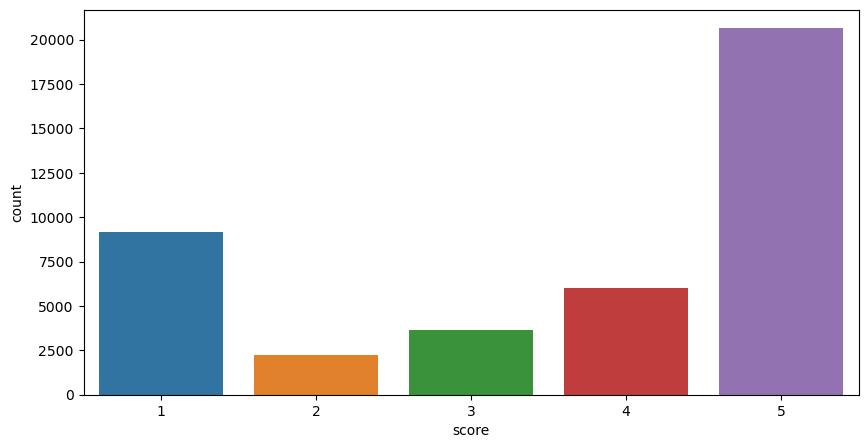

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='score', data=df_comments, ax=ax)

plt.show()


In this approach, let's consider that every comment with scores 1, 2 and 3 are negative comments. In the other hand, comments with score 4 and 5 will be considered as positive. Again, probably this is not the best way to train a sentimental analysis model, but for fastness, we will do this assumption and see if we can extract value from it.

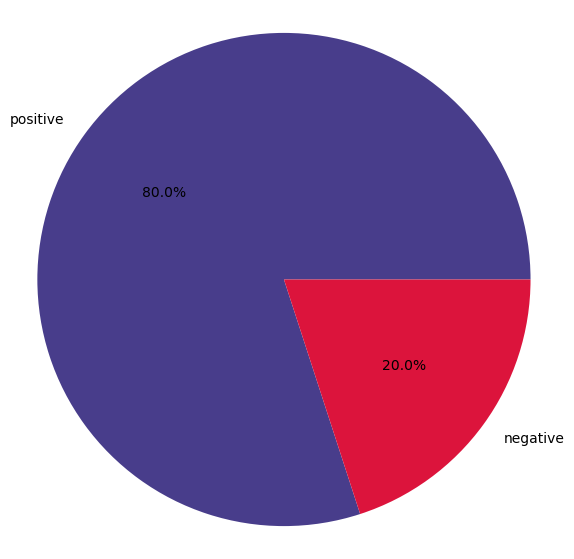

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'comments': ['Great product!', 'Terrible experience!', 'Excellent service!', 'Average quality.', 'Awesome job!'],
    'score': [5, 1, 4, 3, 5]
}
df_comments = pd.DataFrame(data)

# Score mapping
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}

# Label data based on score mapping
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

# Verify results with donut plot
fig, ax = plt.subplots(figsize=(7, 7))
df_plot = df_comments[df_comments['sentiment_label'].isin(['positive', 'negative'])]
sentiment_counts = df_plot['sentiment_label'].value_counts()
ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['darkslateblue', 'crimson'])
ax.axis('equal')
plt.show()


In [52]:
# n-grams presentes in corpus on positive and negative classes?

In [53]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [54]:
df_comments.head()

comments  score sentiment_label
0        Great product!      5        positive
1  Terrible experience!      1        negative
2    Excellent service!      4        positive
3      Average quality.      3        positive
4          Awesome job!      5        positive

In [55]:
def ngrams_count(positive_comments, negative_comments, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    positive_comments: positive comments to be analyzed [type: pd.Series]
    negative_comments: negative comments to be analyzed [type: pd.Series]
    ngram_range: type of n-gram to be used on analysis [type: tuple]
    n: top limit of n-grams to be shown [type: int, default: -1]
    """

    # Using CountVectorizer to build a bag of words using the given positive and negative comments
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(pd.concat([positive_comments, negative_comments]))
    bag_of_words_pos = vectorizer.transform(positive_comments)
    bag_of_words_neg = vectorizer.transform(negative_comments)
    
    sum_words_pos = bag_of_words_pos.sum(axis=0)
    sum_words_neg = bag_of_words_neg.sum(axis=0)
    
    words_freq_pos = [(word, sum_words_pos[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq_neg = [(word, sum_words_neg[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    
    words_freq_pos = sorted(words_freq_pos, key=lambda x: x[1], reverse=True)
    words_freq_neg = sorted(words_freq_neg, key=lambda x: x[1], reverse=True)
    
    total_list_pos = words_freq_pos[:n]
    total_list_neg = words_freq_neg[:n]

    # Returning DataFrames with the n-gram counts for positive and negative comments
    count_df_pos = pd.DataFrame(total_list_pos, columns=['ngram', 'count'])
    count_df_neg = pd.DataFrame(total_list_neg, columns=['ngram', 'count'])
    
    return count_df_pos, count_df_neg


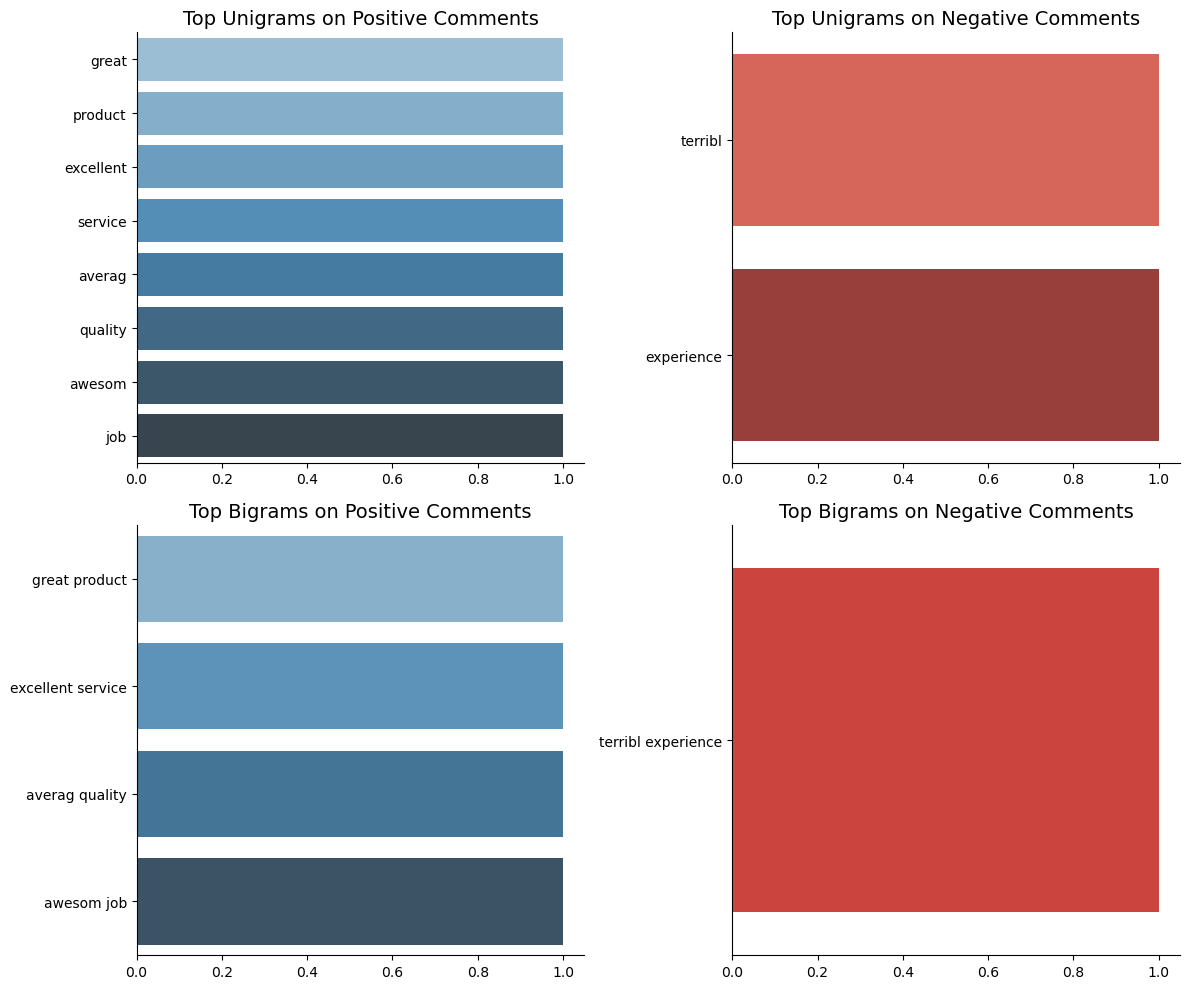

In [56]:
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a stemmer instance
stemmer = SnowballStemmer('portuguese')

# Apply stemming to the 'corpus' column of df_comments
df_comments['stemming'] = df_comments['comments'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Define the ngrams_count function
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

# Splitting the stemmed corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': ngrams_count(positive_comments, (1, 1), 10),
    'Top Unigrams on Negative Comments': ngrams_count(negative_comments, (1, 1), 10),
    'Top Bigrams on Positive Comments': ngrams_count(positive_comments, (2, 2), 10),
    'Top Bigrams on Negative Comments': ngrams_count(negative_comments, (2, 2), 10),
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Removing right spines
    sns.despine(ax=ax, right=True)
    
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()


In [57]:
df_comments.columns

Index(['comments', 'score', 'sentiment_label', 'stemming'], dtype='object')

In [58]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Separate positive and negative comments
positive_comments = df_comments[df_comments['sentiment_label'] == 'positive']['comments'].tolist()
negative_comments = df_comments[df_comments['sentiment_label'] == 'negative']['comments'].tolist()

# Function to print n-grams
def print_ngrams(comments, ngram_range):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(comments)
    feature_names = vectorizer.get_feature_names_out()
    for idx, comment in enumerate(comments):
        comment_ngrams = X[idx].toarray()[0]
        ngrams = [(feature_names[i], count) for i, count in enumerate(comment_ngrams) if count > 0]
        print(f"Comment {idx+1}: {comment}")
        for ngram, count in ngrams:
            print(f"{ngram}: {count}")
        print()

# Print unigrams for positive comments
print("Positive Unigrams:")
print_ngrams(positive_comments, (1, 1))

# Print bigrams for positive comments
print("Positive Bigrams:")
print_ngrams(positive_comments, (2, 2))

# Print unigrams for negative comments
print("Negative Unigrams:")
print_ngrams(negative_comments, (1, 1))

# Print bigrams for negative comments
print("Negative Bigrams:")
print_ngrams(negative_comments, (2, 2))


Positive Unigrams:
Comment 1: Great product!
great: 1
product: 1

Comment 2: Excellent service!
excellent: 1
service: 1

Comment 3: Average quality.
average: 1
quality: 1

Comment 4: Awesome job!
awesome: 1
job: 1

Positive Bigrams:
Comment 1: Great product!
great product: 1

Comment 2: Excellent service!
excellent service: 1

Comment 3: Average quality.
average quality: 1

Comment 4: Awesome job!
awesome job: 1

Negative Unigrams:
Comment 1: Terrible experience!
experience: 1
terrible: 1

Negative Bigrams:
Comment 1: Terrible experience!
terrible experience: 1



The barcharts above are interesting and they really reflect the sentiment based on ngrams. We can clearly see negative words on bigrams and trigrams by the right side of the figure (the most frequent trigram neg receb produt in english maybe means something like didn't receive the product for example).

The positive bigrams and trigrams at the blue left side of the figure really consists of positive words (the most frequent trigram entreg ant praz means something like delivery before time in english). Also!

# Pipeline

So, after detailing all the steps considered on this text prep pipeline, let's build a code to apply a complete pipeline automatically to handle it. This is a important step on the project because with this we can receive a text input and apply all changes on it to make it ready for training or predicting the sentiment label.

In [59]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [60]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

Just to remember, in the pipeline above we chose the TF-IDF approach to extract features from text using the same parameters we used on the examples (max_features=300, min_df=7, max_df=0.8). It means that every text string in our corpus will be 300 "text features" respecting the criteria defined by the min_df and max_df parameters. Let's apply it.

In [61]:
# Defining X and y 
idx_reviews = olist_order_reviews['review_comment_message'].dropna().index
score = olist_order_reviews['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(olist_order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 33402 - Length of one element: 300
Length of X_test_processed: 8351 - Length of one element: 300


## Sentiment Classification

Well, we went trought a lot of steps together and this is the final one! After all the text preparation we've done, it's now time to put it together into a classification model to train an algorithm that understands wherever a text string has a positive or a negative feeling based on the features we extracted from the corpus.

So, let's use a homemade class for make the training and analysis easier.

In [62]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

## Training the models

### LOGISTIC REGRESSION

In [68]:
# Importing the necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

idx_reviews = olist_order_reviews['review_comment_message'].dropna().index
score = olist_order_reviews['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(olist_order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Creating an instance of the Logistic Regression model
lr = LogisticRegression()

# Training the model
lr.fit(X_train, y_train)

# Predicting the labels for the test set
y_pred = lr.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Mapping the predicted labels to positive or negative comments
predicted_sentiment = ['positive' if label == 1 else 'negative' for label in y_pred]
print("Predicted Sentiment:", predicted_sentiment)

Accuracy: 0.884085738234942
Confusion Matrix:
[[1845  476]
 [ 492 5538]]
Predicted Sentiment: ['negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'posi

### GAUSSIAN NAiVE BAYES

In [82]:
from sklearn.naive_bayes import GaussianNB
# Splitting into train and test sets
X = list(olist_order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.20, random_state=42)

# Creating an instance of the Gaussian Naive Bayes model
gnb = GaussianNB()

# Training the model
gnb.fit(X_train, y_train)

# Predicting the labels for the test set
y_pred1 = gnb.predict(X_test)

# Calculating the accuracy of the model
ac1 = accuracy_score(y_test, y_pred1)
print("Accuracy:", ac1)

# Creating the confusion matrix
cm1 = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:", cm1)

# Mapping the predicted labels to positive or negative comments
predicted_sentiment = ['positive' if label == 1 else 'negative' for label in y_pred]
print("Predicted Sentiment:", predicted_sentiment)


Accuracy: 0.8377439827565561
Confusion Matrix: [[2003  318]
 [1037 4993]]
Predicted Sentiment: ['negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'pos

## Evaluating models

In [85]:
from sklearn.metrics import classification_report

# Creating an instance of the Logistic Regression model
lr.fit(X_train, y_train)

# Predicting the labels for the test set
y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Generating the classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:" , (classification_rep))

Confusion Matrix:
[[1845  476]
 [ 492 5538]]
Classification Report:               precision    recall  f1-score   support

           0       0.79      0.79      0.79      2321
           1       0.92      0.92      0.92      6030

    accuracy                           0.88      8351
   macro avg       0.86      0.86      0.86      8351
weighted avg       0.88      0.88      0.88      8351



In [86]:
# Gassian Navye bias
# Creating the confusion matrix
cm1 = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:")
print(cm1)

# Printing the classification report for the negative class
class_names = ['negative', 'positive']
print("Negative Class Classification Report:")
print(classification_report(y_test, y_pred1, target_names=class_names, labels=[0]))

print("Positive Class Classification Report:")
print(classification_report(y_test, y_pred1, target_names=class_names, labels=[1]))


Confusion Matrix:
[[2003  318]
 [1037 4993]]
Negative Class Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.86      0.75      2321

   micro avg       0.66      0.86      0.75      2321
   macro avg       0.66      0.86      0.75      2321
weighted avg       0.66      0.86      0.75      2321

Positive Class Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.83      0.88      6030

   micro avg       0.94      0.83      0.88      6030
   macro avg       0.94      0.83      0.88      6030
weighted avg       0.94      0.83      0.88      6030



## Confusion Matrix

#### Logestic Regression

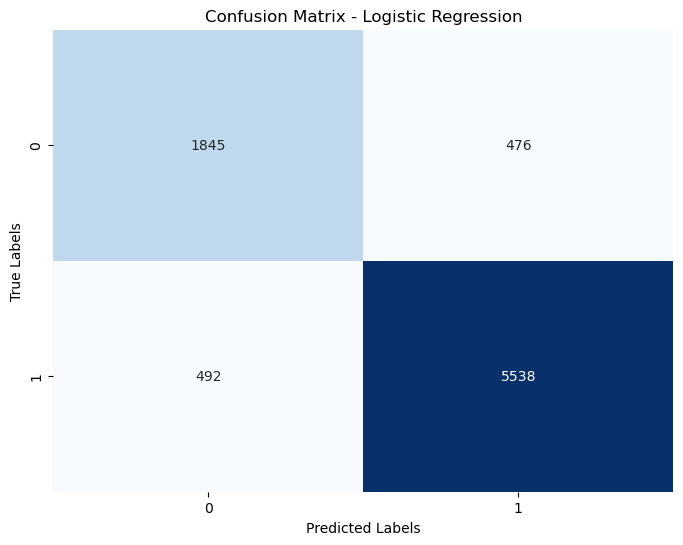

In [75]:
# Confusion matrix of logestic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


#### Gaussian Naive Bayes

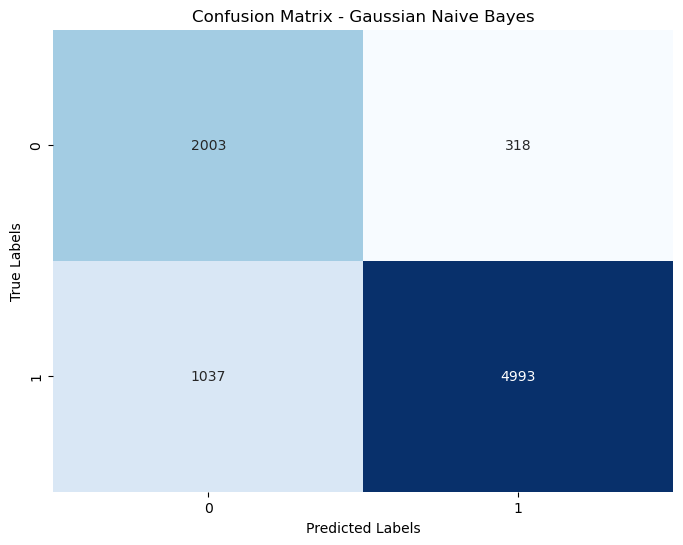

In [87]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Final Implementation

Finally we can build up our final step to delivery a Sentiment Analysis model! We have a full prep pipeline, a machine learning model (to choose) and now the only thing we can do to improve it is to build a connected solution that can receive a input text string (say an e-commerce comment) and return its sentiment. Let's try!

In [88]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """
    
    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)
    
    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

In [90]:
# Defining transformers for preparing the text input
model = lr
prod_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer()))
])
vectorizer = text_pipeline.named_steps['text_features'].vectorizer


Now let's try to write a phrase to feed our sentiment_analysis function. In production, we can adapt it to serve any application. So, let's simulate an online review that says something like Very bad product! I don't buy on this store anymore, the delivery was late and it cost so much money.

What's the sentiment of this given phrase?

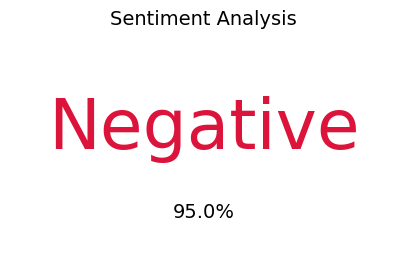

In [91]:
comment = 'Péssimo produto! Não compro nessa loja, a entrega atrasou e custou muito dinheiro!'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

Excelent! Our model returned exactly we expected. Now, let' simulate a comment that says something like I love it and it really fulfilled the expectations. I bought for a cheap value. Wonderful.

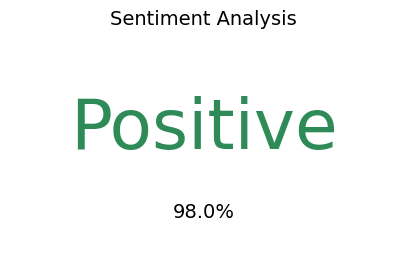

In [92]:
comment = 'Adorei e realmente cumpriu as expectativas. Comprei por um valor barato. Maravilhoso'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

At least, let's try to simulate a very neutral comment. Something like I don't know if a liked this product. The cost was cheap but it was defectuous. If you're lucky, it worths

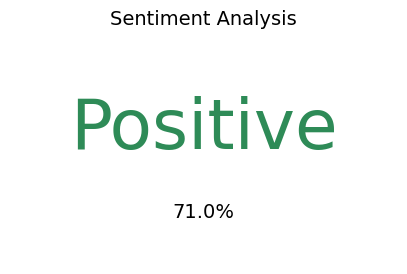

In [93]:
comment = 'Não sei gostei do produto. O custo foi barato mas veio com defeito. Se der sorte, vale a pena'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)